# Artificial Neural Network implementation
Python implementation of the ANN (artificial neural network) architecture.

This code is aimed to be for educational purposes.

This Jupyter Notebook provides a Python implementation of an artificial neural network (ANN) architecture. The purpose of this implementation is to serve as an educational resource for anyone interested in understanding how ANNs work and how they can be implemented in Python, taking into account the specific parts in which I struggled.

The implementation includes the necessary components for building a feedforward neural network, including input, hidden, and output layers. The network is trained using the backpropagation algorithm with stochastic gradient descent.

The implementation also includes a range of options for customizing the network, including the number of layers, the number of neurons in each layer, the activation function used for each neuron, and the learning rate used in the backpropagation algorithm.

Overall, this Jupyter Notebook provides a comprehensive and customizable implementation of an ANN architecture that can be used to develop a better understanding of how ANNs work and how they can be applied in a wide range of contexts.

# Setup

In [145]:
import matb
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

# Derivatives
I am building the derivative mathematical object, not in a symbolic manner but using an analytical approach, answering the question: how does the function respond to a little movement on the x-axis (for one input function) called $h$?

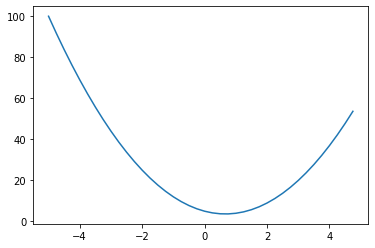

In [10]:
f = lambda x: 3*(x**2) - 4*x + 5
xs = np.arange(-5, 5, 0.25)
ys = f(inputs)
plt.plot(xs, ys);

In [25]:
h = 1e-4
x = 3.0

print(f'f({x}) = {f(x)}')
print(f'f({x} + {h}) = {f(x + h)}')

f(3.0) = 20.0
f(3.0 + 0.0001) = 20.001400030000006


To converge to the **real** derivative $h$ has to be minimized, taking care of not occurring in numerical approximations problems while dealing with FPs.

In [56]:
h = 1e-4

unnormalized_slope = f(x+h) - f(x)
print(f'Unnormalized slope of f(x) (x = {x}) = {unnormalized_slope}')

derivative = unnormalized_slope / h
print(f'Derivative of f(x) (x = {x}) = {derivative}')

Unnormalized slope of f(x) (x = 3.0) = 0.0014000300000063248
Derivative of f(x) (x = 3.0) = 14.000300000063248


## Using multi-variable functions
Multi-variable methods have one dependent variable and more than one independent variable. Do not confuse them with multivariate functions, which in turn have many dependent variables. 

In [57]:
h = 1e-4

a = 2.0
b = -3.0
c = 10.0
d = lambda a,b,c: a*b + c

d_value =  d(a, b, c)

print('Derivative of d(a, b, c) w.r.t. a =', (d(a+h, b, c) - d_value)/h)
print('Derivative of d(a, b, c) w.r.t. b =', (d(a, b+h, c) - d_value)/h)
print('Derivative of d(a, b, c) w.r.t. c =', (d(a, b, c+h) - d_value)/h)

Derivative of d(a, b, c) w.r.t. a = -3.000000000010772
Derivative of d(a, b, c) w.r.t. b = 2.0000000000042206
Derivative of d(a, b, c) w.r.t. c = 0.9999999999976694


# Neural networks
The following is the definition of a Value, which is used to formulate complex math expressions through the concatenation of Values (i.e., atoms).

In [148]:
class Value:
    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(data = {self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def __floordiv__(self, other):
        return Value(self.data / other.data, (self, other), '//')
    
    def __truediv__(self, other):
        return Value(self.data // other.data, (self, other), '/')

## Chained math expression
$$L = ((a \times b) + c) \times f$$

In [220]:
def create_expr():
    a = Value(2.0, label = 'a'); a.grad = 6
    b = Value(-3.0, label = 'b'); b.grad = -4
    c = Value(10.0, label = 'c'); c.grad = -2.0
    e = a * b; e.label = 'e'; e.grad = -2.0
    d = e + c; d.label = 'd';  d.grad = -2.0
    f = Value(-2.0); f.label = 'f'; f.grad = 4.0
    L = d * f; L.label = 'L'; L.grad = 1.0
    return L

Let's define a function to print the **computational graph** out of the math expression.

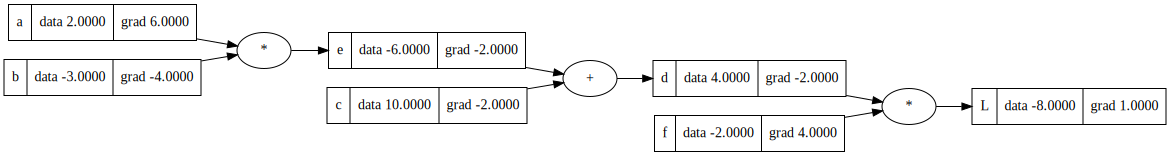

In [221]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = '{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

draw_dot(create_expr())

## Back-propagation
I am interested in the derivative of the final node (i.e., loss function) w.r.t. the leaf nodes.

The baseline derivative (i.e. derivative $L$ w.r.t. itself):
$$\frac{dL}{dL} = 1$$

In [186]:
def baseline_derivative(h: int = ):
    expr_value = create_expr().data
    baseline_derivative = (expr_value + h - expr_value) / h
    print('Baseline derivative of L = %.4f' % (baseline_derivative))

baseline_derivative()

Baseline derivative of L = 1.0000


What happens when the derivative of $L$ is computed w.r.t. the local nodes (the ones in the layer immediately before)? 

For the node $f$:
$$\frac{dL}{df} = \frac{d(d \times f)}{df} = \frac{(d \times (f + h)) - (d \times f)}{h} = \frac{df + dh - df}{h} = \frac{dh}{h} = d$$

For the node $d$:
$$\frac{dL}{dd} = \frac{d(d \times f)}{dd} = \frac{((d + h) \times f) - (d \times f)}{h} = \frac{df + fh - df}{h} = \frac{fh}{h} = f$$

In [210]:
def derivative_L_wrt_d(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        d.data += h
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node d = %.4f' % (derivative))

derivative_L_wrt_d()

Derivative of L w.r.t. leaf node d = -2.0000


Now, how can I derive a non-local derivative? In other words, how can I compute the derivative of $L$ w.r.t. the non-local nodes ($c$, $e$, $a$, and $b$)? 

To compute how $c$ affects $L$ - besides calculating the derivative of $L$ w.r.t. $d$ - compute how $d$ is sensitive to $c$ and link the two components somehow. Let's proceed with the calculus of the local derivative(s):

$$\frac{dd}{dc} = \frac{d(c + e)}{dc} = \frac{((c + h) + e) - (c + e)}{h} = \frac{h}{h} = 1$$

Similarly, compute the local derivative of $d$ w.r.t. $e$:

$$\frac{dd}{de} = \frac{d(c + e)}{de} = \frac{(c + (e + h)) - (c + e)}{h} = \frac{h}{h} = 1$$

Finally, use the chain rule for computing $\frac{dL}{dc}$ and $\frac{dL}{de}$:
$$\frac{dL}{dc} = \frac{dL}{dd} \times \frac{dd}{dc}$$

$$\frac{dL}{de} = \frac{dL}{dd} \times \frac{dd}{de}$$

In [211]:
def derivative_L_wrt_e(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        e.data += h
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node e = %.4f' % (derivative))

derivative_L_wrt_e()

Derivative of L w.r.t. leaf node e = -2.0000


In [212]:
def derivative_L_wrt_c(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        c.data += h
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node c = %.4f' % (derivative))

derivative_L_wrt_c()

Derivative of L w.r.t. leaf node c = -2.0000


In the same way, I use the chain rule for computing $\frac{dL}{da}$ and $\frac{dL}{db}$:

$$\frac{dL}{da} = \frac{dL}{de} \times\frac{de}{da}$$

$$\frac{dL}{db} = \frac{dL}{de} \times\frac{de}{db}$$

The reason why above I did not write $\frac{dL}{da} = \frac{dL}{dd} \times \frac{dd}{de} \times\frac{de}{da}$ is that $\frac{dL}{dd}$ is somehow **incapsulated** inside $\frac{dL}{de}$. The same applies for the derivative w.r.t. $b$.

In [214]:
def derivative_L_wrt_b(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        b = Value(-3.0, label = 'b')
        b.data += h
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node b = %.4f' % (derivative))
    
def derivative_L_wrt_a(h: int = 1e-6):
    def create_expr(h: int = 0):
        a = Value(2.0, label = 'a')
        a.data += h
        b = Value(-3.0, label = 'b')
        c = Value(10.0, label = 'c')
        e = a * b; e.label = 'e'
        d = e + c; d.label = 'd'
        f = Value(-2.0); f.label = 'f'
        L = d * f; L.label = 'L'
        return L
    
    derivative = (create_expr(h).data - create_expr().data) / h
    print('Derivative of L w.r.t. leaf node a = %.4f' % (derivative))

derivative_L_wrt_a()
derivative_L_wrt_b()

Derivative of L w.r.t. leaf node a = 6.0000
Derivative of L w.r.t. leaf node b = -4.0000


## Gradient updating
Once I have computed the gradient for each of the nodes in the graph, I can adjust their value according to the gradient of the final value w.r.t. them.